# Schrödinger's Worm and 2-qubit gates

## Objectives
* Design, build, and test quantum circuits that model systems in superposition and entanglement.
* Learn additional error mitigation & reduction techniques

## Setup codes
* Run the next cells to set things up

In [ ]:
%pip install qiskit qiskit-ibm-runtime qiskit-aer
!pip install pylatexenc matplotlib

## Superposition

In this lab, we will investigate how superpositions work by a thought experiment / numerical experiment, *Schr\"odinger's Worm*, which is suppose to be analogous to Schr\"odinger's cat.

For this, we want to think about a worm with five segments, each represented by a square in the cartoon below.

When the worm is alive, when all five squares are healthy and pink.  The worm will be considered to have died when only four are healthy, and instead one is sick or mortally wounded. Mathematically, lets take a <b>0 to represent a healthy segment</b> and <b>1 to represent a sick square</b> as in the figure:

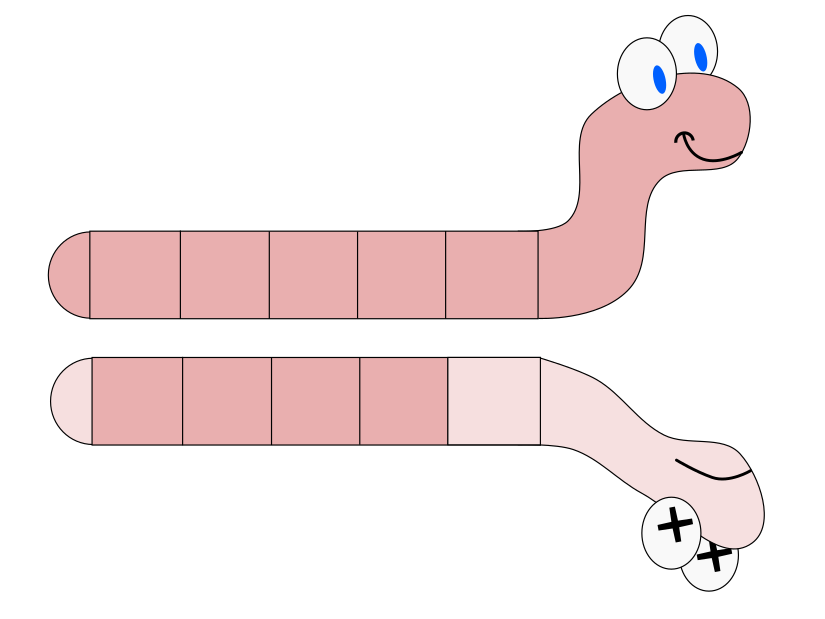

Representing the five segments as a state $|q_4 q_3 q_2 q_1 q_0\rangle$ were the segments are number in descending order from left to right.

* What is the <b>classical state of the live</b> 5-bit worm?

=============================

$|q_4 q_3 q_2 q_1 q_0\rangle=$ ???????

=============================

* What is the <b>classical state of the dead</b> 5-bit worm?

=============================

$|q_4 q_3 q_2 q_1 q_0\rangle=$ ???????

=============================

* Use IBM Composer to create a worm in <b>a superposition state of alive and dead</b>. Let q[0] correspond to the bit on the far right. (Hint, remember that the composer initializes all qubits to 0)
* Can you modify the circuit so that the worm is <b>first put in a superposition state and then brought to life</b>?
* Can you modify the circuit so that the worm in a superposition state <b>becomes definitely dead</b>?

## Entanglement

Now suppose in addition to the worm, there is a hungry bird whose attention it has attracted, such that the worm is either alive or chomped to multiple pieces (as in the cartoon below)

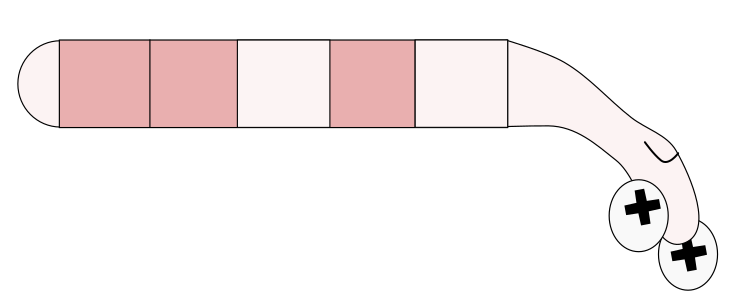


7.  What is the classical state of the very dead worm?

=============================

$|q_4 q_3 q_2 q_1 q_0\rangle=$ ???????

=============================

* Create a circuit in IBM Composer that produces a worm in a superposition state of alive and very dead. (Hint: Two of the qubits are entangled.)
* Can  you  modify  the  circuit  so  that  the  worm  in  a  superposition  state becomes either definitely dead or definitely alive?

# Working with "real" machines

If I've understood what the previous sections asked, then the IBM Composer circuit for the worm near the bird is given by:

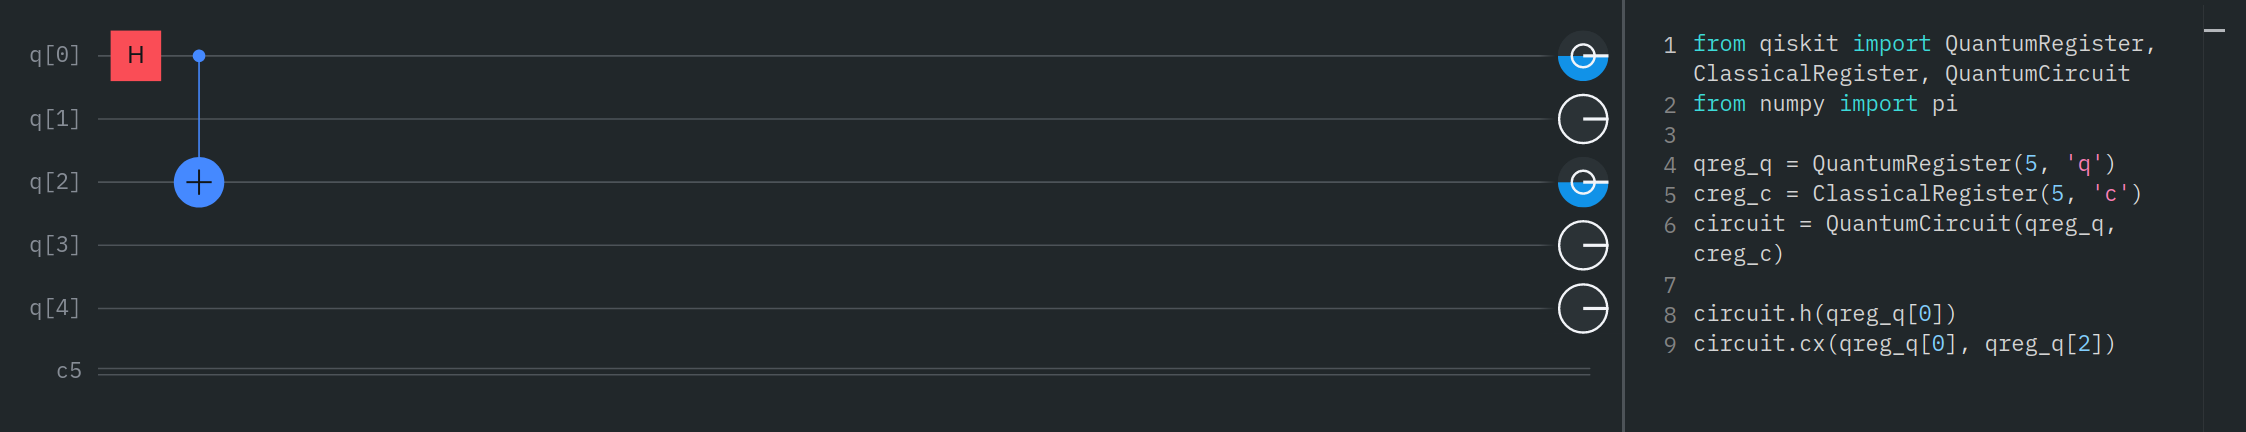

Unlike the circuits in the previous labs, this one has a 2-qubit gate (the CNOT).  On real hardware, these gates typically have 100s or 1000s times larger gate errors than 1-qubit gates.  So lets investigate this by running our circuit on a simulator that accounts for this noise.

In order to run on actual devices, we need to perform at least 1 measurement.  If we want to know the state of the entire worm, we need to measure every qubit

* In the cell below, **copy the QisKit code from the IBM Composer for your worm**

* <b>Add a measure_all() </b> at the end of your circuit

* In the next cell, I have set up a simulator with a noise model based on a real device.  Run your circuit using this

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2
from qiskit.visualization import plot_histogram

# Run the sampler job locally using FakeNairobiV2
fake_nairobi = FakeNairobiV2()
pm = generate_preset_pass_manager(backend=fake_nairobi, optimization_level=3)
transpiled_circuit = pm.run(circuit)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}

#Set up the Sampler simulater backend
sampler = Sampler(backend=fake_nairobi, options=options)

#Run the circuits, and get results
result = sampler.run([transpiled_circuit]).result()

#Plot the result
plot_histogram(result[0].data.meas.get_counts())

* How does this probabilities compare to your theoretical expectations ($p_{alive}=p_{dead}=0.5$)

During our lab yesterday, we discussed how often there is an asymmetry in the readout error -- measuring $|0\rangle$ is typically easier to do more accurately then $|1\rangle$.  For this reason, if you can reduce the number of qubits in the $|1\rangle$ state at the end, typically you will be more accurate.

* Reconfigure your circuit in the cell below such that dead segements are $|1\rangle$ and live segments are $|0\rangle$.

* Run this new circuit on the noisy simulator.

* Record the resulting frequencies below and compute the probabilities for being alive or dead, do you see a difference from your original results?


In [ ]:
#Put your modified code here





# Transpile the ideal circuit to a circuit that can be directly executed by the backend by using "passing" it through the "pass manager"
transpiled_circuit = pm.run(circuit)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}

#Set up the Sampler simulater backend
sampler = Sampler(backend=fake_nairobi, options=options)

#Run the circuits, and get results
result = sampler.run([transpiled_circuit]).result()

#Plot the result
plot_histogram(result[0].data.meas.get_counts())

When you look at your circuit, you might assume that all qubits are created equal.  This is not true for two reasons: connectivity and gate fidelities.  

Connectiviy refers to the graph connecting each qubit to the rest of the computer.  All-to-All connectivity refers to the ability of any set of qubits to be operated upon by a multi-qubit gate.  This requires a substantial amount of hard work on the engineers part, and we don't expect it to be true for large computers.  Instead, we expect qubits to be able to act directly with only a limited number of neighbors, and if nonlocal interactions are needed, multiple SWAP gates will be used to move the state of a given qubit closer to perform the operation.

The graph connecting the qubits of the 127 qubit <b>ibm_sherbrooke</b> is shown in the figure

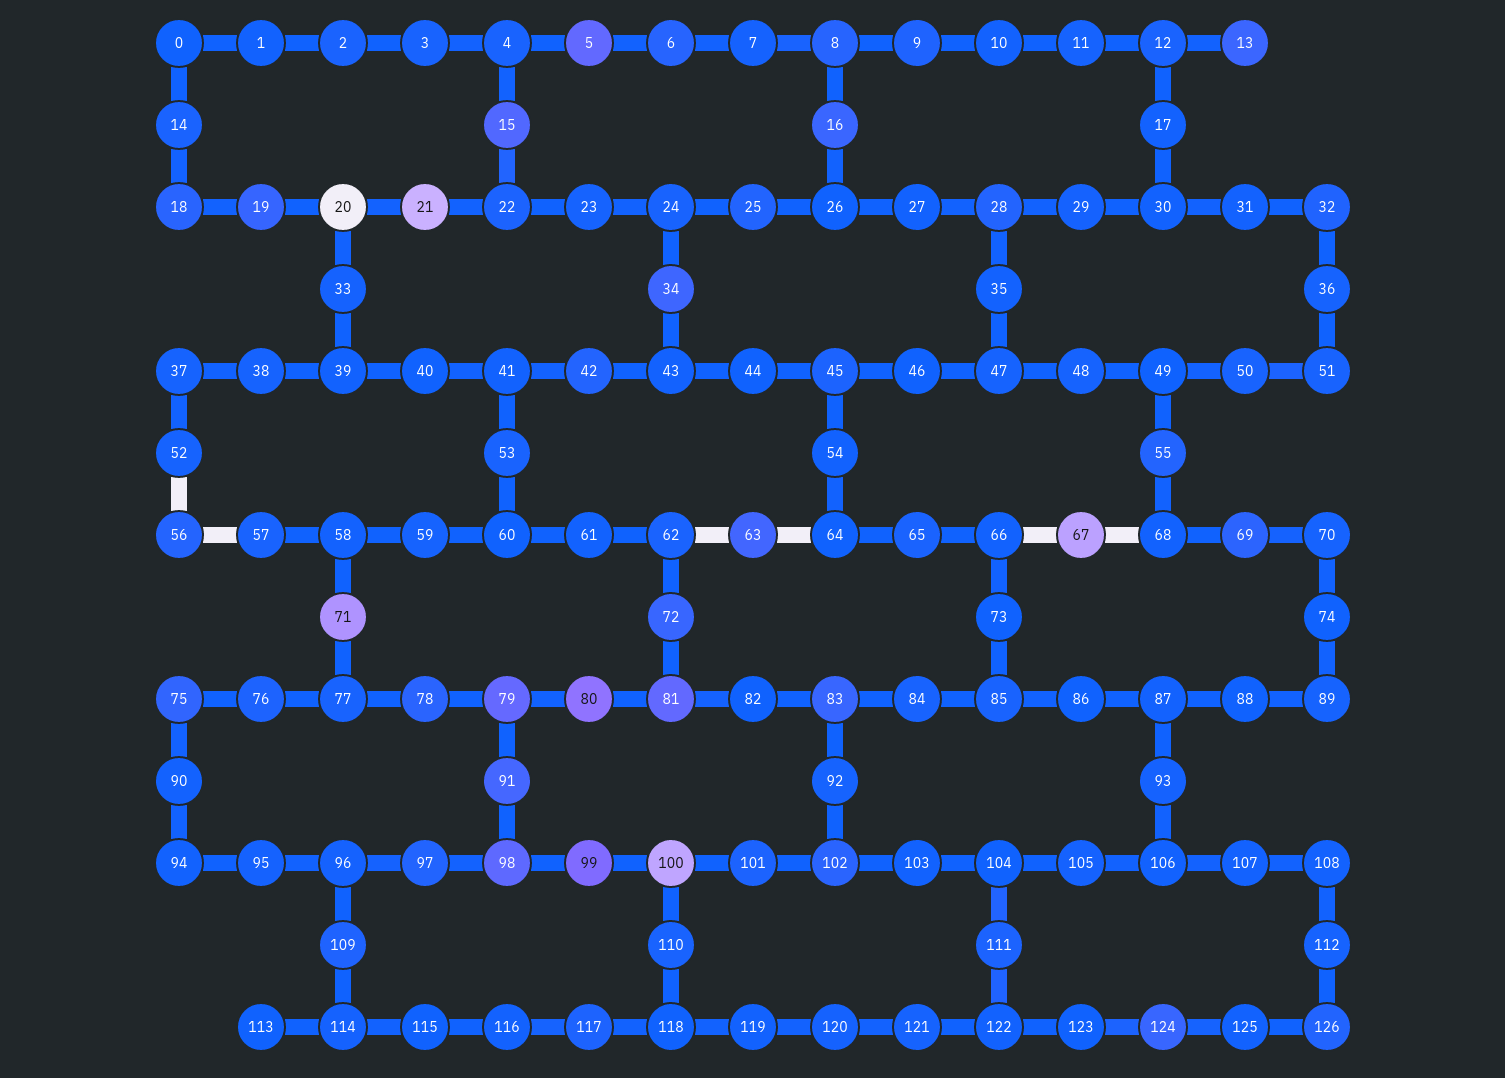

In this graph, Some qubits only allow 2-qubit gates like CNOT with two neighbor qubits, while others can communicate with a three or only one qubit.  This is what we mean by a qubit's connectivity.

In addition to connectivity, different qubits on the same device can have dramatically different 1 and 2 qubit gate fidelities (denoted by the different colors of the links between qubits).  So when optimizing circuits, qubits which are heavily utilized should be mapped to the ones on the architecture with high gate fidelity.

Perhaps you can appreciate how, when you have large devices and complicated algorithms, optimizing the mapping from your code to the actual qubits can be highly nontrivial.  Many engineers, postdocs, graduate students, and undergraduates spend good portions of their time trying to find better mappings for their problems!  Some of this can be performed by a transpiler, but often these aren't as effective as a human looking at the code.  

Lets see if we can do anything to improve your code. To proceed, in the next cell, draw your current circuit.

In [ ]:
transpiled_circuit.draw('mpl')

You probably notice that there are extra CNOTs you didn't put in.  The issue is that the 5-qubit device we looked at doesn't have All-to-All connectivity.  So insted The extra 3 CNOT gates that appear are transpiled versions of the $SWAP$ gate.  These $SWAP$ gates are being used to move the two qubits that you are entangling to be close enough that a CNOT can be acted on between them.

This immediately suggest an optimization.  Since the transpiler seems to be unable to change the initial positions of qubits (because I set the optimization_level=0), let us do it explicitly.

From a mathematical point of view, swapping $q_1,q_2$ is equivalent to the previous model of the worm and bird, except different states are associated with alive and very dead.

* Modify your circuit in the next cell to put the two entangle qubits directly beside each other
* Run this new circuit
* Record the results below, do you see a difference from your previous results?

* <b>Inspect the transpiled version</b> of this new code.  Is it substantially simpler?

In [ ]:
transpiled_circuit.draw('mpl')

Sometimes, there are theoretical reasons to exclude certain final states from the final result because they obviously indicate an error has occured.  Removing these states from your count and normalizing the total number of remain shots can be used to boost your results.  This is called <b>postselection</b>.

In your current code, any state besides $|00000\rangle$ and $|00011\rangle$ could be considered a state that can only occur by qubit errors.  So lets recompute your probabilities.

* Put your previous frequency of alive and dead into the next cell
* <b>How do your probabilities compare</b> to each previous case and the theoretical result?